# Fitting spectroscopic data with Bagpipes

Fitting spectroscopic data is an order of magnitude more complex than fitting photometric data. It's still not entirely clear to me how best to address all the problems that come up, and the answers naturally depend on the data you're dealing with. The following is what I currently believe to be best practice with Bagpipes when dealing with VIMOS spectroscopy such as the Lega-C spectrum in Example 2.

The results of this kind of analysis require very careful consideration to evaulate whether the modelling approach taken is returning reasonable answers and uncertainties. Please don't go getting ahead of yourself the second you see the model correctly lining up with your spectroscopic data!

## Setting up

Let's once again grab the functions from the second example which load up the observational data for us.

In [1]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits
from glob import glob

uvista_filt_list = ["uvista/CFHT_u.txt",
                    "uvista/CFHT_g.txt",
                    "uvista/CFHT_r.txt",
                    "uvista/CFHT_i+i2.txt",
                    "uvista/CFHT_z.txt",
                    "uvista/subaru_z",
                    "uvista/VISTA_Y.txt",
                    "uvista/VISTA_J.txt",
                    "uvista/VISTA_H.txt",
                    "uvista/VISTA_Ks.txt",
                    "uvista/IRAC1",
                    "uvista/IRAC2"]


def load_uvista(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    hdulist = np.loadtxt("UltraVISTA_catalogue.cat",
                         usecols=(0,3,4,5,6,7,8,9,10,11,12,13,14,15,
                                  16,17,18,19,20,21,22,23,24,25,26))

    # Check the object is in the catalogue.
    if np.min(np.abs(hdulist[:,0] - int(ID))) != 0:
        sys.exit("Object not found in catalogue")

    tablerow = np.argmin(np.abs(hdulist[:,0] - int(ID)))

    # Extract the object we're interested in from the catalogue.
    phot_fluxes = hdulist[tablerow, 1:13]
    phot_fluxerrs = hdulist[tablerow, 13:25]

    phot = np.zeros(len(phot_fluxes)*2)
    phot.shape = (len(phot_fluxes), 2)
    
    # Convert to microjanskys
    phot[:,0] = phot_fluxes*10**29
    phot[:,1] = phot_fluxerrs*10**29

    # blow up the errors associated with any N/A points in the phot
    for i in range(len(phot)):
        if ((phot[i, 0] == 0. or phot[i, 1] <= 0) 
                or (phot[i, 1] > 0 and -phot[i, 0] >= 2*phot[i, 1])):
            phot[i,:] = [0., 9.9*10**99.]

    return phot


def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum)/binn
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_legac_spec(ID):
    """ Load legac spectroscopic data from file. """

    hdulist = fits.open(ID + ".fits")

    spectrum = np.zeros((hdulist[1].data["WAVE"].shape[1], 3))

    spectrum[:,0] = hdulist[1].data["WAVE"][0,:]
    spectrum[:,1] = hdulist[1].data["FLUX"][0,:]
    spectrum[:,2] = hdulist[1].data["ERR"][0,:]

    mask = hdulist[1].data["QUAL"][0,:]==1

    spectrum[:,1] *= 10**-19
    spectrum[:,2] *= 10**-19

    spectrum[mask, 2] = 10**10

    spectrum = spectrum[(spectrum[:,0] > 6300.) & (spectrum[:,0] < 8800.),:]

    return bin(spectrum, 4)


def load_both(ID):
    spectrum = load_legac_spec(ID)
    phot = load_uvista(ID)
    
    return spectrum, phot
    
    
galaxy = pipes.galaxy("96976", load_both, filt_list=uvista_filt_list)

fig = galaxy.plot()

<Figure size 1200x800 with 2 Axes>

## A fit instructions dictionary for spectroscopy

Let's start off with a model similar to the double-power-law model we fitted in Example 4 with nebular emission thrown in:

In [2]:
dblplaw = {}                        
dblplaw["tau"] = (0., 15.)            
dblplaw["alpha"] = (0.01, 1000.)
dblplaw["beta"] = (0.01, 1000.)
dblplaw["alpha_prior"] = "log_10"
dblplaw["beta_prior"] = "log_10"
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0., 2.5)

nebular = {}
nebular["logU"] = -3.

dust = {}                           
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)
dust["eta"] = 2.

fit_info = {}
fit_info["redshift"] = (0., 10.)
fit_info["t_bc"] = 0.01
fit_info["redshift_prior"] = "Gaussian"
fit_info["redshift_prior_mu"] = 0.9
fit_info["redshift_prior_sigma"] = 0.05
fit_info["dblplaw"] = dblplaw 
fit_info["nebular"] = nebular
fit_info["dust"] = dust

Now we need to think about a few different issues. Firstly, we need to model the velocity dispersion in the spectrum. Bagpipes does this by convolving the spectroscopic output with a Gaussian kernel in velocity space. We can very the width of this kernel with:

In [3]:
fit_info["veldisp"] = (100., 500.)   #km/s

Now we need to think about relative flux calibration. There are a lot of effects to consider here, for example:
 - Aperture mismatch between spectroscopy and photometry
 - Innaccurate relative flux calibration as a function of wavelength in spectroscopic data
 - Underestimated uncertainties in spectroscopic data
 - Template mismatch between the models and data, which is a minor problem when fitting photometry, but a major one for fitting spectroscopy
 
The first technique I've found to be effective is to introduce a chebyshev polynomial perturbation to the spectroscopic data to deal with any calibration issues and to match the models. This is added to the model by adding a polynomial dictionary to the fit instructions dictionary:

In [4]:
poly = {}
poly["0"] = (0.5, 1.5) # Zero order is centred on 1, at which point there is no change to the spectrum.
poly["0_prior"] = "Gaussian"
poly["0_prior_mu"] = 1.0
poly["0_prior_sigma"] = 0.1

poly["1"] = (-0.5, 0.5) # Subsequent orders are centred on zero.
poly["1_prior"] = "Gaussian"
poly["1_prior_mu"] = 0.
poly["1_prior_sigma"] = 0.1

poly["2"] = (-0.5, 0.5)
poly["2_prior"] = "Gaussian"
poly["2_prior_mu"] = 0.
poly["2_prior_sigma"] = 0.1

poly["3"] = (-0.5, 0.5)
poly["3_prior"] = "Gaussian"
poly["3_prior_mu"] = 0.
poly["3_prior_sigma"] = 0.1

poly["4"] = (-0.5, 0.5)
poly["4_prior"] = "Gaussian"
poly["4_prior_mu"] = 0.
poly["4_prior_sigma"] = 0.1

poly["5"] = (-0.5, 0.5)
poly["5_prior"] = "Gaussian"
poly["5_prior_mu"] = 0.
poly["5_prior_sigma"] = 0.1

fit_info["polynomial"] = poly

Next up is dealing with potentially underestimated errors. We can add a hyperparameter weighting to the spectroscopy to fit out this effect.

In [5]:
fit_info["hypspec"] = (0.00001, 1.)
fit_info["hypspecprior"] = "log_10"

## Fitting the data

It's time to run the sampler. The higher dimensionality of this model means it's going to take a lot longer to sample the parameter space.


Bagpipes: fitting object 96976 with Dynesty


Bagpipes: fitting complete in 7508.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
redshift                       0.971      0.971      0.971
hypspec                        0.243      0.252      0.261
veldisp                      228.991    248.621    263.306
dblplaw:tau                    4.397      4.558      4.696
dblplaw:metallicity            0.185      0.196      0.205
dblplaw:beta                   6.584      8.478     11.008
dblplaw:massformed            10.772     10.796     10.822
dblplaw:alpha                 18.051     20.284     22.422
dust:Av                        0.431      0.474      0.526
polynomial:1                   0.038      0.053      0.068
polynomial:0                   0.977      0.989      1.000
polynomial:3                   0.008      0.018      0.031
polynomial:2           

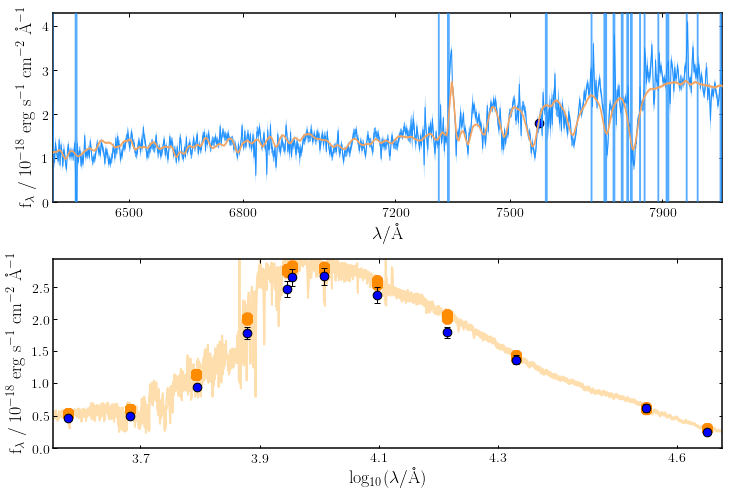

In [8]:
fit = pipes.fit(galaxy, fit_info, run="spectroscopy")

fit.fit()

fig = fit.plot_fit()

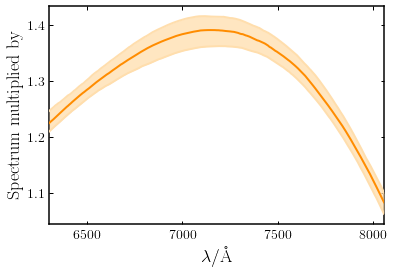

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119900cd0>)

In [8]:
fit.plot_poly()

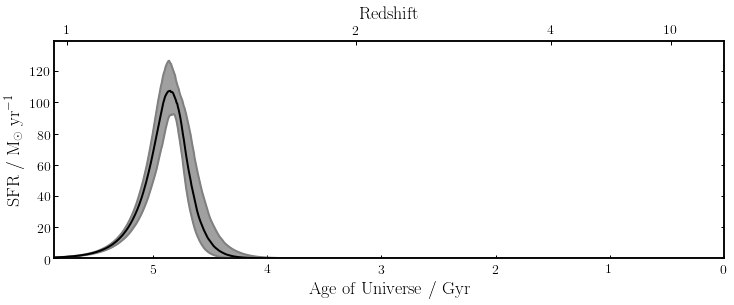

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1aaf256810>)

In [9]:
fit.plot_sfh()

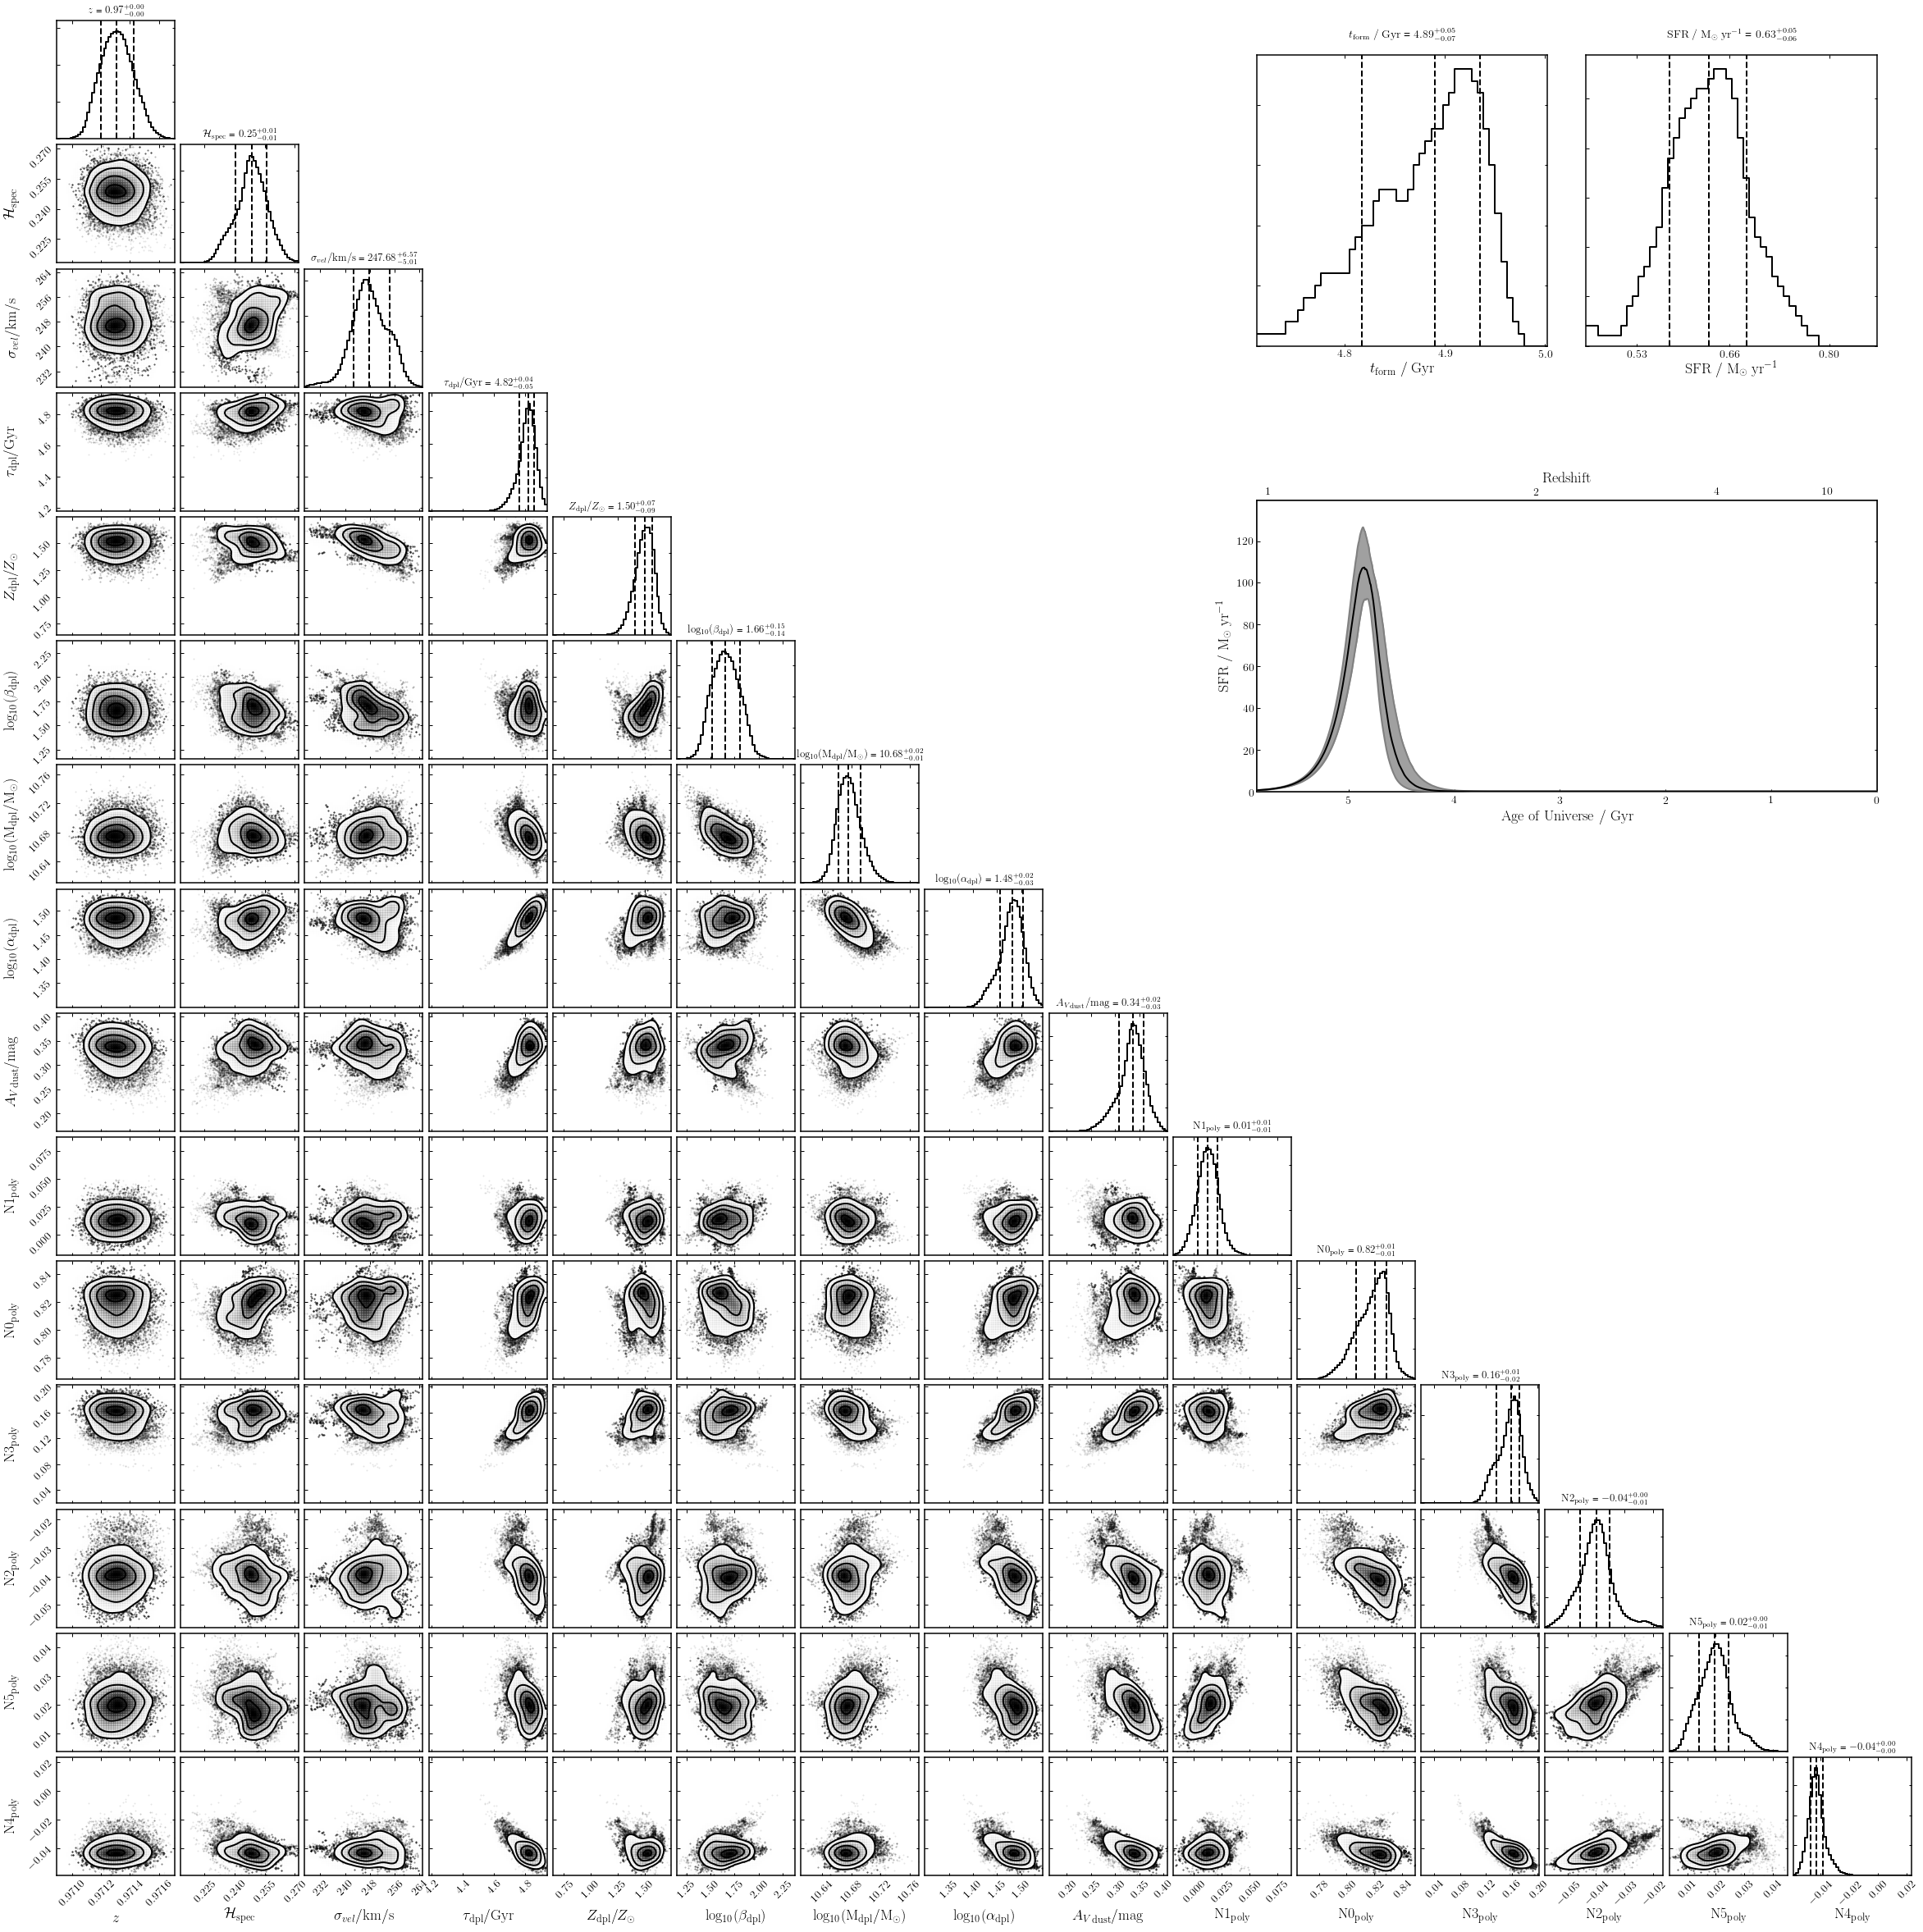

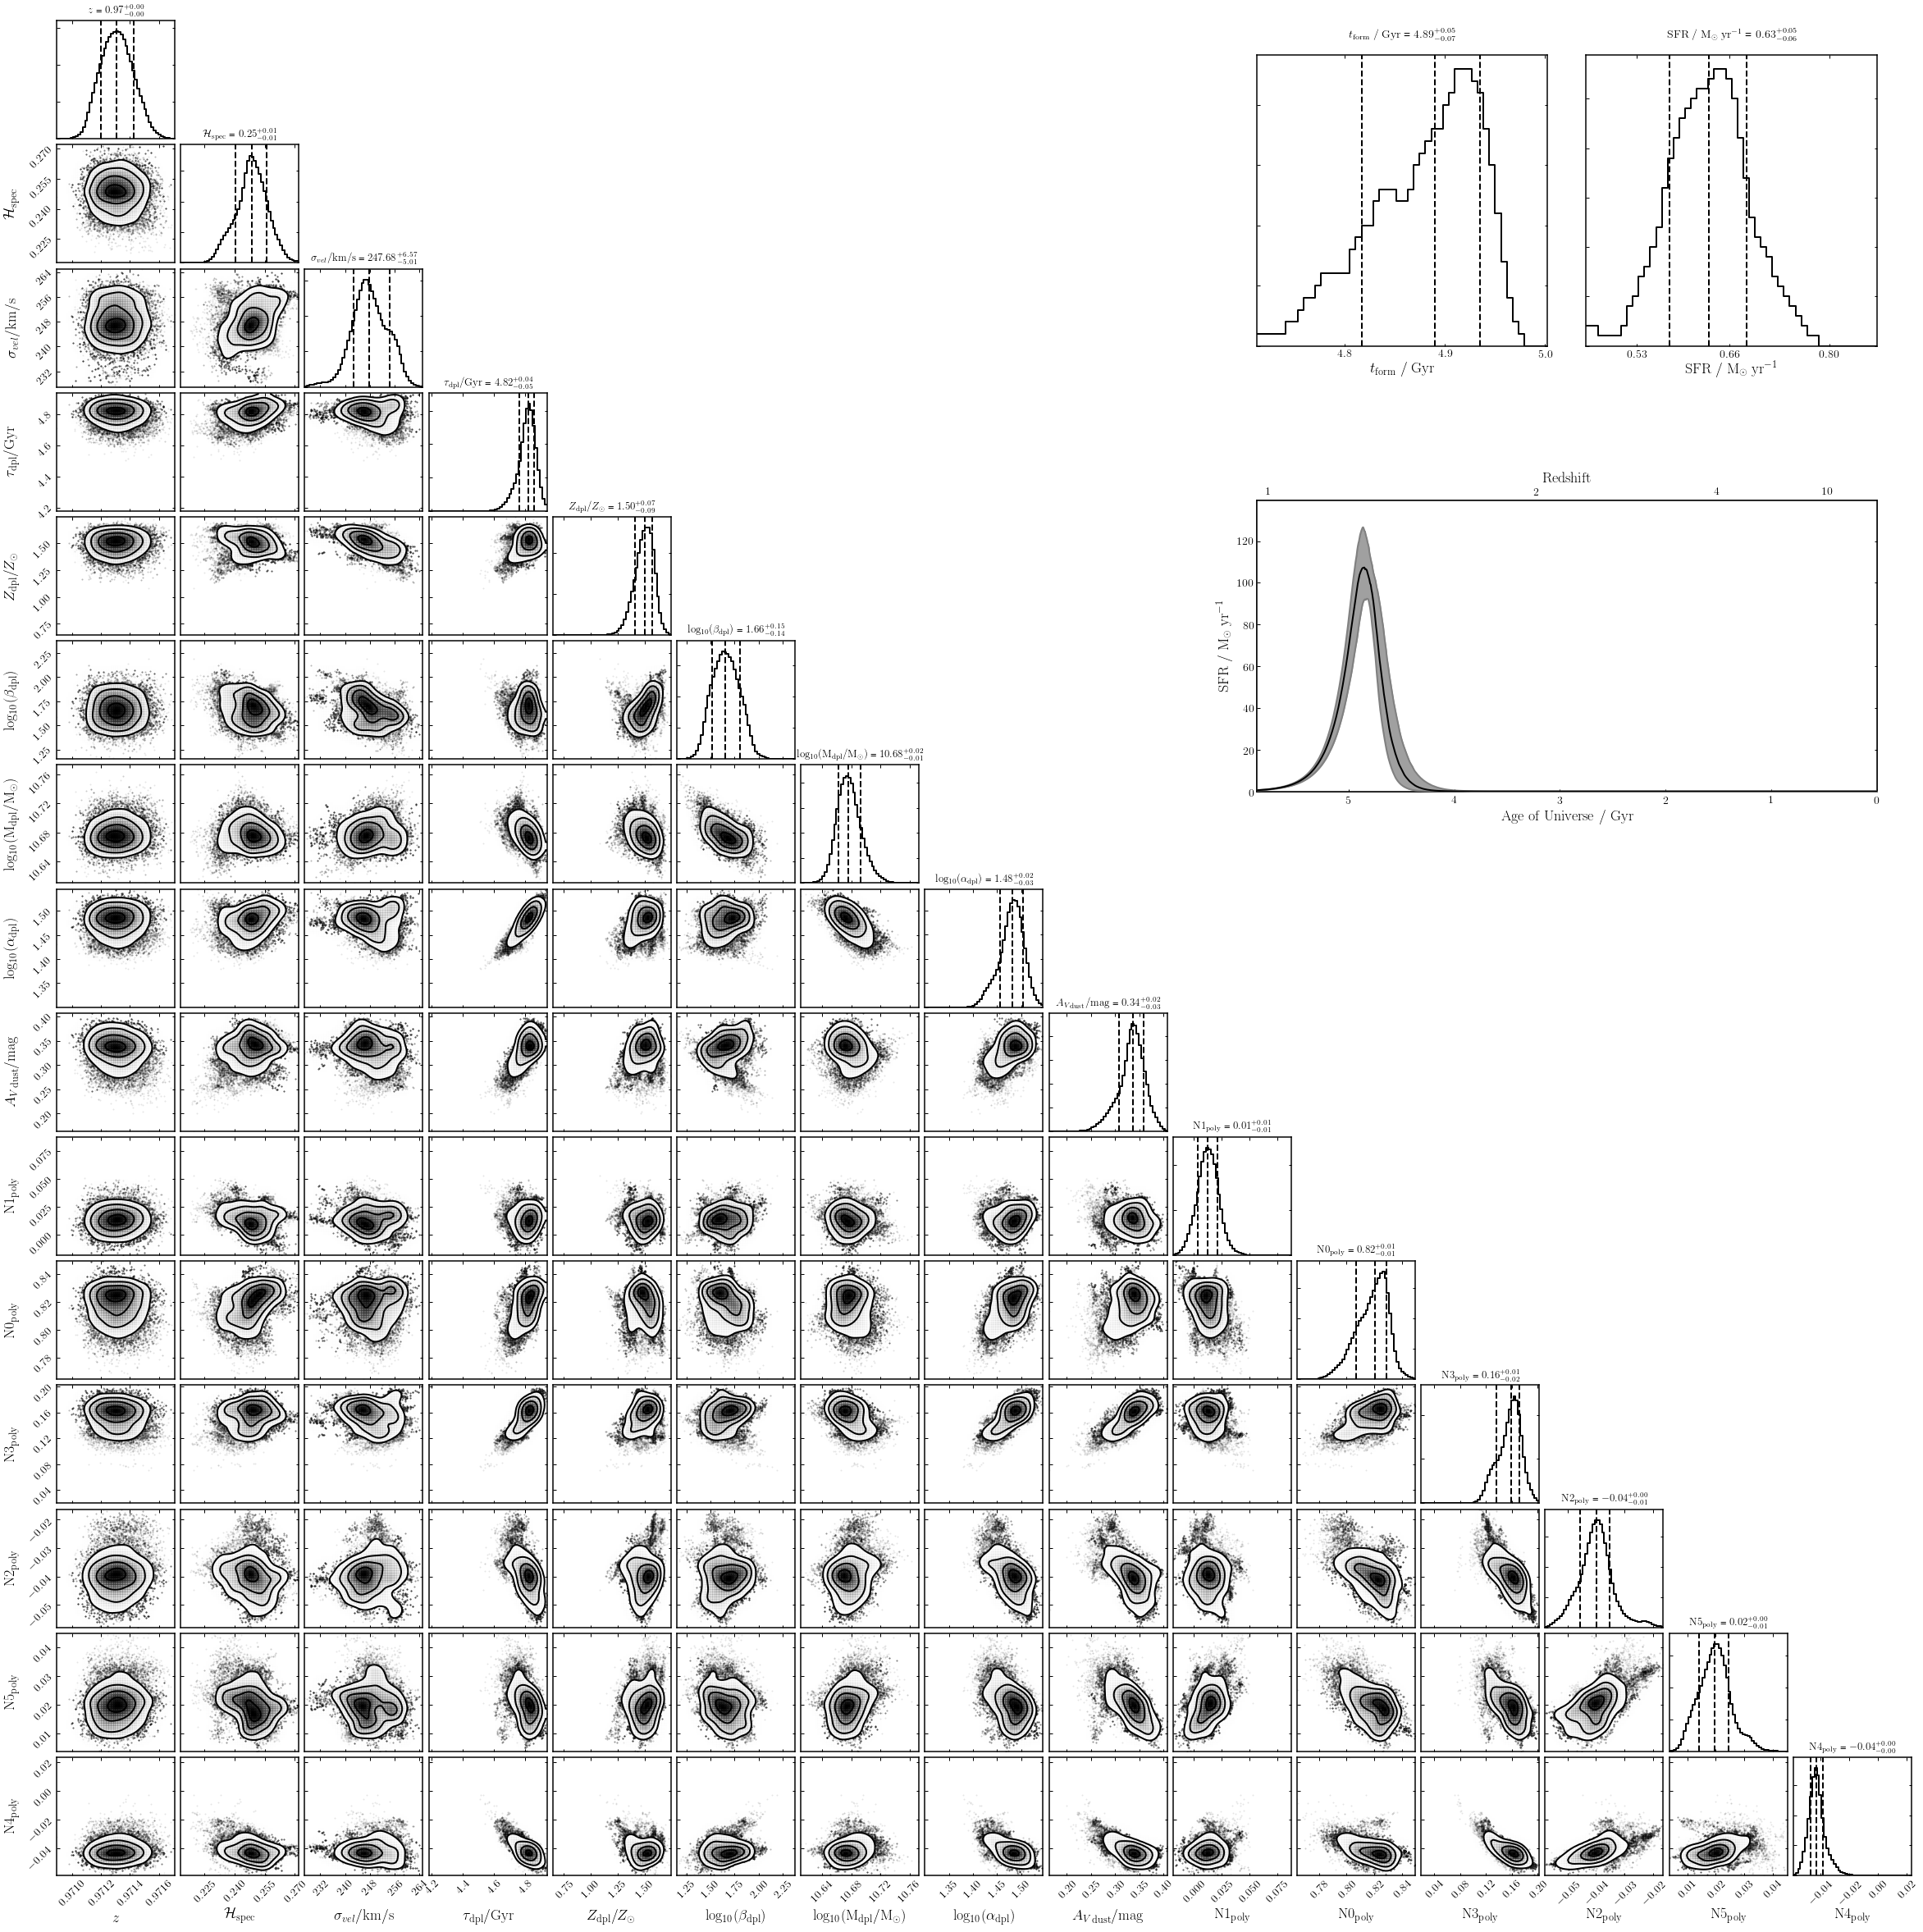

In [10]:
fit.plot_corner()